In [44]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [48]:
# 정규화 (Standard Normal Distribution; Z-Distribution)
'''
상이한 스케일을 가지고 있는 데이터를 같은 스케일로 맞추어줌.
따라서 features 별로 정규화를 진행.
특성의 중앙이 0, 표준편차가 1
'''

mean = train_data.mean(axis=0) #평균
train_data -= mean #Data에서 평균을 뺴주고
std = train_data.std(axis=0) # 표준편차
train_data /= std #표준편차로 나누어준다.

'''
test_data를 정규화 할 때 train_data 정규화 값을 사용하는 것은
머신러닝 작업 과정에서는 절대로 test_data의 어떠한 계산 값도 사용해서는 안되기 때문임.
'''
test_data -= mean
test_data /= std

In [85]:
from keras import models
from keras import layers

# Model 설정

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))

    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

# mse(mean squared error) : 예측값과 실제값 차이의 제곱의 평균 -> 손실함수
# mae(mean absolute error) : 예측값에서 실제값을 뺸 절대값의 평균 -> 회귀 지표

In [53]:
import numpy as np

# K-Fold cross-validation
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    # validation data & targets 설정
    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]
    
    # train data & targets 설정
    partial_train_data = np.concatenate(
    [
        train_data[ : i * num_val_samples],
        train_data[(i+1) * num_val_samples : ]
    ],axis = 0)
    
    partial_train_targets = np.concatenate(
    [
        train_targets[ : i * num_val_samples],
        train_targets[(i+1) * num_val_samples : ]
    ],axis = 0)
    
    # train
    model = build_model()
    model.fit(partial_train_data, 
              partial_train_targets,
              epochs = num_epochs,
              batch_size = 1,
              verbose = 0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)
    all_scores.append(val_mae)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [54]:
all_scores

[2.2692556381225586, 2.5816445350646973, 2.7791450023651123, 2.788029193878174]

In [55]:
np.mean(all_scores)

2.6045185923576355

In [59]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    # validation data & targets 설정
    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]
    
    # train data & targets 설정
    partial_train_data = np.concatenate(
    [
        train_data[ : i * num_val_samples],
        train_data[(i+1) * num_val_samples : ]
    ],axis = 0)
    partial_train_targets = np.concatenate(
    [
        train_targets[ : i * num_val_samples],
        train_targets[(i+1) * num_val_samples : ]
    ],axis = 0)
    
    # train
    model = build_model()
    history = model.fit(partial_train_data, 
              partial_train_targets,
              validation_data = (val_data,val_targets),
              epochs = num_epochs,
              batch_size = 1,
              verbose = 0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

In [63]:
len(all_mae_histories[1])

500

In [72]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

In [73]:
average_mae_history

[4.67791610956192,
 3.480359435081482,
 3.1571342945098877,
 2.9613420963287354,
 2.767665922641754,
 2.7105504274368286,
 2.8029330372810364,
 2.6692289113998413,
 2.6051226258277893,
 2.640128791332245,
 2.528464198112488,
 2.6340473294258118,
 2.5236607789993286,
 2.510834753513336,
 2.541802167892456,
 2.598159372806549,
 2.5647018551826477,
 2.4323275089263916,
 2.387522041797638,
 2.462836444377899,
 2.481344759464264,
 2.455168843269348,
 2.474673271179199,
 2.395323693752289,
 2.3566982448101044,
 2.407798707485199,
 2.416453003883362,
 2.435180127620697,
 2.4437021911144257,
 2.3814793527126312,
 2.3793500661849976,
 2.413863182067871,
 2.4850675463676453,
 2.3420552909374237,
 2.53409481048584,
 2.3877081871032715,
 2.4726256132125854,
 2.431568682193756,
 2.478433847427368,
 2.4444792568683624,
 2.337092489004135,
 2.3910308480262756,
 2.393100678920746,
 2.367350995540619,
 2.348621129989624,
 2.3436235785484314,
 2.5261083245277405,
 2.5152177810668945,
 2.418330729007721,

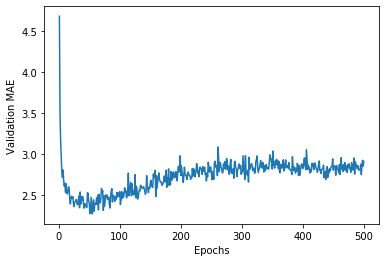

In [75]:
import matplotlib.pyplot as plt


plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

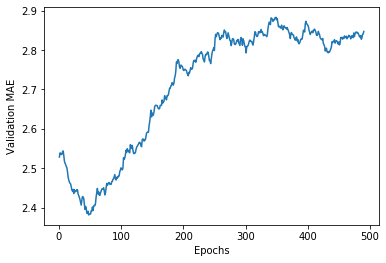

In [80]:
# exponential moving average(smooth curve)

def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [87]:
# 최종모델 훈련
model = build_model()
model.fit(train_data,
          train_targets,
          epochs = 80,
          batch_size = 16,
          verbose = 0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

test_mae_score

102/102 [==============================] - 0s 1ms/step


2.691136598587036